In [116]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_tensor_type('torch.DoubleTensor')
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.nn.utils import spectral_norm
import numpy as np
import utils
import mlmodel
import matplotlib.pyplot as plt
import collections.abc
import re
import copy

In [117]:

import warnings
warnings.filterwarnings('ignore')
torch.set_printoptions(precision=10)

In [118]:
import sys
if sys.platform == 'win32':
    NUM_WORKERS = 0 # Windows does not support multiprocessing
else:
    NUM_WORKERS = 2
print('running on ' + sys.platform + ', setting ' + str(NUM_WORKERS) + ' workers')

running on darwin, setting 2 workers


## Load the Dataset

In [119]:
dim_a = 3
features = ['v', 'q', 'pwm']
label = 'fa'

# Training data collected from the neural-fly drone
dataset = 'neural-fly' 
dataset_folder = 'data/training'
hover_pwm_ratio = 1.

# # Training data collected from an intel aero drone
# dataset = 'neural-fly-transfer'
# dataset_folder = 'data/training-transfer'
# hover_pwm = 910 # mean hover pwm for neural-fly drone
# intel_hover_pwm = 1675 # mean hover pwm for intel-aero drone
# hover_pwm_ratio = hover_pwm / intel_hover_pwm # scaling ratio from system id

modelname = f"{dataset}_dim-a-{dim_a}_{'-'.join(features)}" # 'intel-aero_fa-num-Tsp_v-q-pwm'

In [120]:
RawData = utils.load_data(dataset_folder)
Data = utils.format_data(RawData, features=features, output=label)

testdata_folder = 'data/experiment'
TestRawData = utils.load_data(testdata_folder, expnames='(baseline_)([0-9]*|no)wind')
TestData = utils.format_data(RawData, features=features, output=label, hover_pwm_ratio=hover_pwm_ratio) # wind condition label, C, will not make sense for this data - that's okay since C is only used in the training process

In [121]:
options = {}
options['dim_x'] = Data[0].X.shape[1]
options['dim_y'] = Data[0].Y.shape[1]
options['num_c'] = len(Data)
print('dims of (x, y) are', (options['dim_x'], options['dim_y']))
print('there are ' + str(options['num_c']) + ' different conditions')

dims of (x, y) are (11, 3)
there are 6 different conditions


In [122]:
options['features'] = features
options['dim_a'] = dim_a
options['loss_type'] = 'crossentropy-loss'

options['shuffle'] = True # True: shuffle trajectories to data points
options['K_shot'] = 32 # number of K-shot for least square on a
options['phi_shot'] = 256 # batch size for training phi

options['alpha'] = 0.01 # adversarial regularization loss
options['learning_rate'] = 5e-4
options['frequency_h'] = 2 # how many times phi is updated between h updates, on average
options['SN'] = 2. # maximum single layer spectral norm of phi
options['gamma'] = 10. # max 2-norm of a
options['num_epochs'] = 1000

## Process Tasks Data

In [123]:
train_tasks = {}
for i, data in enumerate(Data):
  if data.condition not in train_tasks.keys():
    train_tasks[data.condition] = []
  train_tasks[data.condition] = data

In [124]:
test_tasks = {}
for i, data in enumerate(Data):
  if data.condition not in test_tasks.keys():
    test_tasks[data.condition] = []
  test_tasks[data.condition] = data

In [125]:
all_data = train_tasks.copy()

In [126]:
target_data={}
target_data["10"] = train_tasks["10"]

In [127]:
train_tasks.pop("10")
source_data = train_tasks

## Create Neural Network

In [128]:
def maybe_sn(m, use_sn):
    return spectral_norm(m) if use_sn else m

In [129]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, spectral_norms, random = True):
        super().__init__()
        assert len(hidden_dims) == len(spectral_norms)
        layers = []
        for dim, use_sn in zip(hidden_dims, spectral_norms):
            x = nn.Linear(input_dim, dim)
            layers += [
                x,
                nn.ReLU(inplace=True),
            ]
            if not random:
                x.weight = nn.Parameter(torch.ones_like(x.weight))
                

            input_dim = dim

        layers += [nn.Linear(input_dim, output_dim)]
        # self.layer_list = nn.ModuleList(layers)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [130]:
hidden_dim = [32,32]
spectral_norms = [False]*len(hidden_dim)
NN = MLP(options["dim_x"], 6, hidden_dim, spectral_norms, False)

## Helper Functions

In [294]:
# Randomly select data from dataset
def sample_data(data, size):
  number_of_rows = data.shape[0]
  random_indices = np.random.choice(number_of_rows, 
                                    size=size, 
                                    replace=False)
  return random_indices

In [132]:
def extract_features(rawdata, features):
  feature_data = []
  for feature in features:
    if isinstance(rawdata[feature], str):
      condition_list = re.findall(r'\d+', rawdata[feature]) 
      condition = 0 if condition_list == [] else float(condition_list[0])
      feature_data.append(np.tile(condition,(len(rawdata['v']),1)))
      continue
    feature_len = rawdata[feature].shape[1] if len(rawdata[feature].shape)>1 else 1
    if feature == 'pwm':
        feature_data.append(rawdata[feature] / 1000 * hover_pwm_ratio)
    else:
        feature_data.append(rawdata[feature].reshape(rawdata[feature].shape[0],feature_len))
    # print(feature_data) 
  feature_data = np.hstack(feature_data)
  return feature_data

In [133]:
def generate_task_sample(NN, data, shared_features, idx, sample_size, eps):
    shared_input = extract_features(data,shared_features)
    # env_input = extract_features(data,env_features)
    random_indices = sample_data(shared_input, size = int(sample_size))
    sub_sample = shared_input[random_indices,:]
    # sub_features = env_input[random_indices,:]
    shared_y = NN(torch.Tensor(sub_sample)).detach().numpy()
    # norm_sub_features = np.apply_along_axis(lambda x :(x+1)/np.linalg.norm((x+1)) , 0, sub_features)
    # print(norm_sub_features.shape)
    # sub_features = np.apply_along_axis(lambda x :(x+1)/np.linalg.norm((x+1)) , 0, sub_features)
    # y = shared_y + idx + (sub_features/np.linalg.norm(sub_features)).reshape(shared_y.shape) + eps
    sub_features = np.zeros((1,6))
    sub_features[0][idx] = np.mean(data["t"])
    # sub_sample = np.concatenate([sub_sample,np.tile(sub_features, (len(random_indices),1))],axis = 1)
    mul = np.dot(sub_features, shared_y.T)
    # if not len(mul) == 0:
    #     mul *= (10/mul.max())
    if eps: 
        # y = shared_y * (sub_features[:,0]+norm_sub_features[:,1]).reshape(shared_y.shape)+ np.random.normal(0,1,shared_y.shape).reshape(shared_y.shape)
        y = mul + np.random.normal(0,0.01,mul.shape)
    else:
        # y = shared_y * (sub_features[:,0]+norm_sub_features[:,1]).reshape(shared_y.shape)
        y = mul
    return sub_sample, y.T

In [134]:
def generate_sample(NN, raw_data, sample_size, v, shared_features, env_features, eps=True):
  keys = list(source_data.keys())
  sample = np.array([]).reshape(0,options["dim_x"])
  ys = np.array([]).reshape(0,1)
  for idx, vi in enumerate(v):
    data = raw_data[idx]
    teak_sample_size = int(sample_size*vi)
    sub_sample, y = generate_task_sample(NN, data, shared_features, idx, teak_sample_size, eps)
    sample = np.vstack([sample, sub_sample])
    ys = np.vstack([ys, y])
  return sample, ys

In [ ]:
generate_sample(NN, RawData, RawData[0]["v"].shape[0], [1],features, ["condition", "t"], False)

In [135]:
def generate_sample_H(NN, raw_data, sample_size, v, shared_features, env_features, task_data = None, eps=True):
  if task_data is None:
    task_data_x = {}
    task_data_y = {}
    for idx, vi in enumerate(v):
      task_data_x[idx] = np.array([]).reshape(0,options["dim_x"])
      task_data_y[idx] = np.array([]).reshape(0,1)
    task_data = [task_data_x, task_data_y]
  task_data_x, task_data_y = task_data
  for idx, vi in enumerate(v):
    data = raw_data[idx]
    task_sample_size = int(sample_size*vi)
    sub_sample, y = generate_task_sample(NN, data, shared_features, idx, task_sample_size, eps)
    task_data_x[idx] = np.vstack([task_data_x[idx], sub_sample])
    task_data_y[idx] = np.vstack([task_data_y[idx], y])
  return task_data_x, task_data_y

## Training + Inference

Create target neural network with same complexity with generated neural network

In [271]:
input, true_y = generate_task_sample(NN, RawData[0], features, 0, 100, False)

In [137]:

def train(model, optimizer, criterion, train_x, train_y, epoch):
  loss_lst = []
  for i in range(epoch):
    optimizer.zero_grad()
    outputs = model(torch.Tensor(train_x))
    loss = criterion(outputs, torch.Tensor(train_y))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
    optimizer.step()
    loss_lst.append(loss.item())
  return model, loss_lst

In [393]:
def predict(target_nn, input, true_y):
  prediction = target_nn(torch.Tensor(input))
  mse = np.square(np.subtract(true_y,prediction.detach().numpy())).mean()
  return mse

In [291]:
def run(RawData, v, sample_size_range, hidden_dim,train_epoch):
  predict_loss = []
  for i, sample_size in enumerate(sample_size_range):
    train_epoch = int(sample_size * 0.1 + 0.5)
    spectral_norms = [False]*len(hidden_dim)
    model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train_x, train_y = generate_sample(NN, RawData, sample_size, v, features, ["condition","t"], True)
    # train_x, train_y = generate_task_sample(NN, RawData[0], features, 0, sample_size, False)
    model, train_loss = train(model, optimizer, criterion, train_x, train_y, train_epoch)
    # input, true_y = generate_task_sample(NN, RawData[0], features, 0, RawData[0]["v"].shape[0], False)
    mse = predict(model, input, true_y)
    predict_loss.append(mse)
  return model,predict_loss

In [ ]:
generate_sample(NN, RawData, RawData[0]["v"].shape[0], [1],features, ["condition", "t"], False)

## Baseline Experiments

### Baseline 1: uniformly select from source tasks

Create target neural network with same complexity with generated neural network

In [295]:
hidden_dim = [32,32,6]
spectral_norms = [False]*len(hidden_dim)
uniform_nn = MLP(options["dim_x"], 1, hidden_dim, spectral_norms)
criterion = nn.MSELoss()
optimizer = optim.SGD(uniform_nn.parameters(), lr=0.001, momentum=0.9)

In [296]:
v = np.array([1]*len(all_data.keys()))
v = v / (len(all_data.keys()))
sample_size_range = np.arange(20000,40000,5000)
uniform_mean_loss = []
for episode in range(5):
  print(episode)
  target_nn,loss_lst = run(RawData, v, sample_size_range, hidden_dim, 100)
  uniform_mean_loss.append(loss_lst)

0
1
2
3
4


Text(0, 0.5, 'MSE loss')

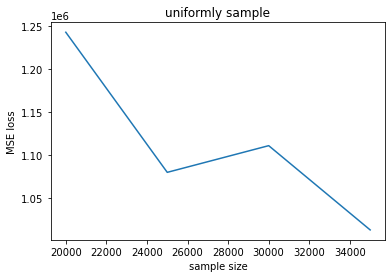

In [297]:
plt.plot(sample_size_range, np.mean(uniform_mean_loss,axis=0))
plt.title("uniformly sample")
plt.xlabel("sample size")
plt.ylabel("MSE loss")

### Baseline 2: best situation

In [54]:
hidden_dim = [32,32,6]
spectral_norms = [False]*len(hidden_dim)
best_nn = MLP(options["dim_x"], 1, hidden_dim, spectral_norms)
criterion = nn.MSELoss()
optimizer = optim.SGD(best_nn.parameters(), lr=0.001, momentum=0.9)

With known environment variables, largely select on the most related source tasks. Here, the most related tasks is the same environment with target task (same wind condition)

In [186]:
v = [1, 0, 0, 0, 0, 0]
sample_size_range = np.arange(100,2000,100)
best_mean_loss = []
for episode in range(10):
  best_nn,loss_lst = run(RawData, v, sample_size_range, hidden_dim, 100)
  best_mean_loss.append(loss_lst)

Text(0, 0.5, 'MSE loss')

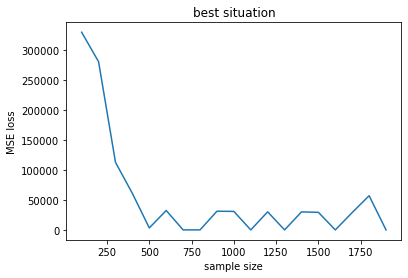

In [187]:
plt.plot(sample_size_range, np.mean(best_mean_loss,axis=0))
plt.title("best situation")
plt.xlabel("sample size")
plt.ylabel("MSE loss")

In [189]:
best_nn.net[-1].weight

Parameter containing:
tensor([[-1.8706176445,  0.1013083361, -0.0101368004,  0.1629567196,
         -1.8995683545, -3.9267956085]], requires_grad=True)

### Compare

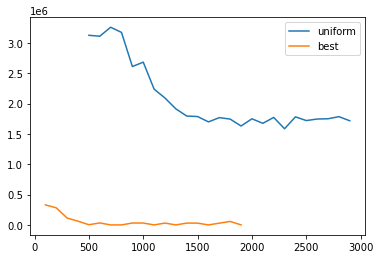

In [188]:
rng = np.arange(500,3000,100)
plt.plot(rng, np.mean(uniform_mean_loss,axis=0)[4:], label = "uniform")
plt.plot(np.arange(100,2000,100), np.mean(best_mean_loss,axis=0), label = "best")
plt.legend()
plt.show()

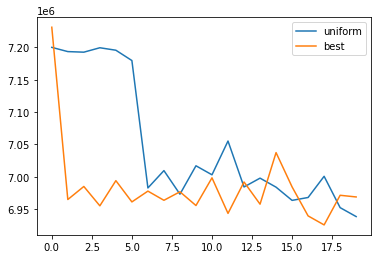

In [113]:
rng = np.arange(0,20,1)
plt.plot(rng, np.mean(uniform_mean_loss,axis=0), label = "uniform")
plt.plot(rng, np.mean(best_mean_loss,axis=0), label = "best")
plt.legend()
plt.show()

## Active Learning

In [386]:
def update_v(ws, best_w):
  new_v = np.linalg.lstsq(ws.detach().numpy().T, best_w.detach().numpy())[0]
  new_v = np.abs(new_v/np.linalg.norm(new_v,2))
  # new_v = np.apply_along_axis(lambda x: max(0.1, x), 0, [new_v])[0]
  return new_v

In [387]:

def estimate(active_nn, input, true_y, ws, hidden_dim, v):
  results = []
  new_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms)
  new_model.load_state_dict(active_nn.state_dict())
  for w in ws:
    new_model.net[-1].weight = nn.parameter.Parameter(torch.unsqueeze(w, dim=0))
    result = predict(new_model, input, true_y)
    results.append(result)
  best_w_idx = np.argmin(results)
  # print(ws)
  # print(best_w_idx)
  best_w = ws[best_w_idx]
  # active_nn.net[-1].weight = nn.parameter.Parameter(torch.unsqueeze(best_w, dim=0))
  v = 0.8 * v + 0.2 * update_v(ws, best_w)
  # v = np.array([1]*len(RawData))
  # v = v / (len(RawData))
  v = np.apply_along_axis(lambda x: max(0.167, x), 0, [v])
  if not len(v.shape) == 1:
    v = v[0]
  return v, best_w

In [395]:
def active_training(raw_data, train_epoch, v, shared_features, env_features, max_size):
  v = np.array([1]*len(raw_data))
  v = v / (len(raw_data))
  # input, true_y = generate_task_sample(NN, RawData[0], features, 0, RawData[0]["v"].shape[0], False)
  hidden_dim = [32,32,6]
  spectral_norms = [False]*len(hidden_dim)
  active_nn = MLP(options["dim_x"], 1, hidden_dim, spectral_norms)
  criterion = nn.MSELoss()
  optimizer = optim.SGD(active_nn.parameters(), lr=0.001, momentum=0.9)
  ws = torch.ones_like(active_nn.net[-1].weight)
  ws = ws.tile(len(RawData),1)
  
  # train_x, train_y = generate_sample_H(NN, raw_data, int(max_size * 0.2), v, shared_features, env_features)
  train_x, train_y = generate_sample_H(NN, raw_data, int(max_size*0.4), v, shared_features, env_features)


  # input, true_y = generate_sample(NN, RawData, RawData[0]["v"].shape[0], [1],features, ["condition","t"], False)
  for i, p in enumerate(np.tile([0.2],4)):
    sample_size = int(max_size*p)
    for idx, vi in enumerate(v):
      if not i == 0:
        active_nn.net[-1].weight = nn.parameter.Parameter(torch.unsqueeze(ws[idx], dim=0))
        train_epoch = int(len(train_x[idx]) * 0.5 + 0.5)
      active_nn, train_loss = train(active_nn, optimizer, criterion, train_x[idx], train_y[idx], train_epoch)
      ws[idx] = active_nn.net[-1].weight
    v, best_w = estimate(active_nn, input, true_y, ws, hidden_dim, v)
    # print("best_w", best_w)
    # print("after", v)
    train_x, train_y = generate_sample_H(NN, raw_data, sample_size, v, shared_features, env_features,[train_x, train_y])
  active_nn.net[-1].weight = nn.parameter.Parameter(torch.unsqueeze(best_w, dim=0))
  return v, predict(active_nn, input, true_y), active_nn

In [397]:
train_epoch = 100
env_features = ["condition","t"]
sample_size_range = np.arange(100,6000,100)
hidden_dim = [32,32,6]
spectral_norms = [False]*len(hidden_dim)
active_nn = MLP(options["dim_x"], 1, hidden_dim, spectral_norms)
criterion = nn.MSELoss()
optimizer = optim.SGD(active_nn.parameters(), lr=0.001, momentum=0.9)
mean_loss = []

In [ ]:
for _ in range(1):
  mse_loss = []
  v = np.array([1]*len(RawData))
  v = v / (len(RawData))
  for sample_size in sample_size_range:
    v, mse,active_nn = active_training(RawData, train_epoch, v, features, ["condition","t"], sample_size)
    mse_loss.append(mse)
    print(v)
  mean_loss.append(mse_loss)

In [398]:
for _ in range(5):
  mse_loss = []
  v = np.array([1]*len(RawData))
  v = v / (len(RawData))
  for sample_size in sample_size_range:
    v, mse,active_nn = active_training(RawData, train_epoch, v, features, ["condition","t"], sample_size)
    mse_loss.append(mse)
  mean_loss.append(mse_loss)

Text(0, 0.5, 'MSE loss')

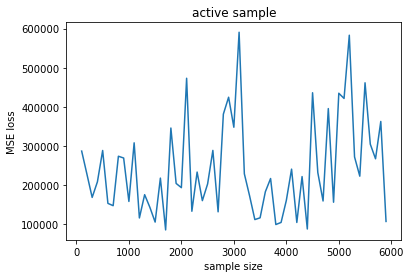

In [399]:
plt.plot(sample_size_range, np.mean(mean_loss, axis=0))
plt.title("active sample")
plt.xlabel("sample size")
plt.ylabel("MSE loss")

### Compare

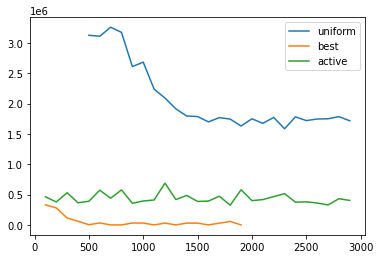

In [270]:
rng = np.arange(500,3000,100)
plt.plot(rng, np.mean(uniform_mean_loss,axis=0)[4:], label = "uniform")
plt.plot(np.arange(100,2000,100), np.mean(best_mean_loss,axis=0), label = "best")
plt.plot(np.arange(100,3000,100), np.mean(mean_loss, axis=0), label = "active")
plt.legend()
plt.show()